In [50]:
%reload_ext autoreload
%autoreload 2
import tie.dbutils as db
import tie.utils as qa
import pandas as pd
from scipy.io import savemat, loadmat
import json
from tqdm import tqdm
import os
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
import numpy as np
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import DivergingNorm, TwoSlopeNorm, Normalize
from statsmodels.stats.multitest import fdrcorrection
import matplotlib.patches as patches
from matplotlib import cm

In [58]:
rc('font', **{'family':'sans-serif',
              'sans-serif':['Helvetica']})
FONT_SIZE = 25
params = {'axes.labelsize': FONT_SIZE,
          'axes.titlesize': FONT_SIZE, 
          'legend.fontsize': FONT_SIZE, 
          'xtick.labelsize': FONT_SIZE, 
          'ytick.labelsize': FONT_SIZE}
matplotlib.rcParams.update(params)
ORDER = [0, 2, 3, 1]
version = 'v5_IRLS'

# Panel a

In [114]:
res_corsi = loadmat(f'../../all_corsi_log_{version}.mat')['all_corsi'][0]

res_2back = loadmat(f'../../all_2back_log_{version}.mat')['all_2back'][0]

res_rtime = loadmat(f'../../all_rtime_log_{version}.mat')['all_r_time']

res_switch = loadmat(f'../../all_switch_log_{version}.mat')['all_switch']

res_sRT = res_rtime[0]
res_cRT = res_rtime[1]
res_global = res_switch[0]
res_local = res_switch[1]


In [68]:
len(res_cRT[0].flat[0])

6

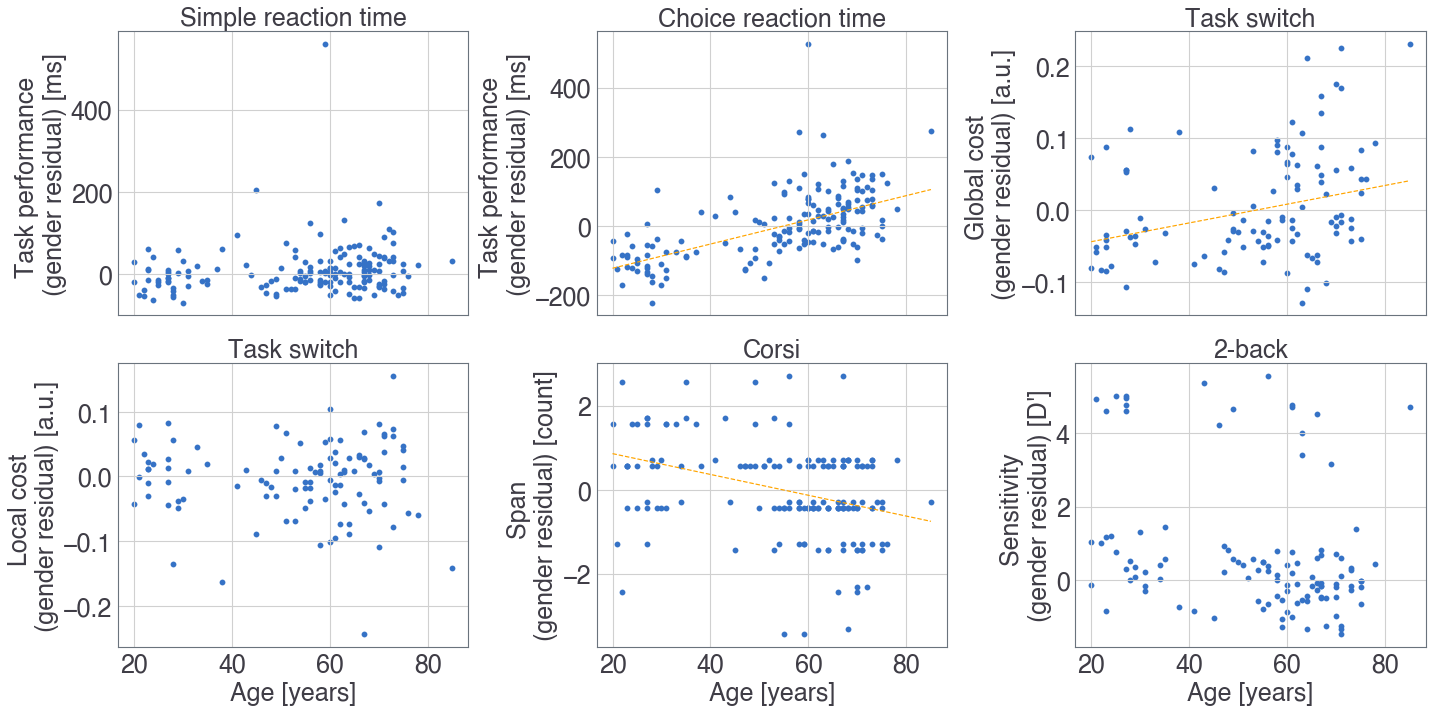

In [93]:
TITLES = ['Simple reaction time', 'Choice reaction time', 'Task switch', 'Task switch', 'Corsi', "2-back"] 
VALUES = [res_sRT, res_cRT, res_global, res_local, res_corsi, res_2back]
fig, ax = plt.subplots(2, 3, figsize=(20, 10), sharex=True)

for IDX in range(6):

    age = VALUES[IDX][0].flat[0][3]
    data_it = VALUES[IDX][0].flat[0][2].flat[0]
    if "OLS" in version:
        k = data_it[9].flat[0][1]
        r2 = data_it[9].flat[0][3]
        p = data_it[9].flat[0][6]
    else:
        k = data_it[9].flat[0][3]
        r2 = data_it[9].flat[0][0]
        p = data_it[9].flat[0][2]
    
    gender_corrected_res = data_it[8]
    
    ax[IDX // 3][IDX % 3].scatter(age, gender_corrected_res)
    if p[0][0] < 0.05:
        ax[IDX // 3][IDX % 3].plot([min(age), max(age)], np.array([min(age), max(age)]) * k[0] + k[1], '--', color='orange')
    ax[IDX // 3][IDX % 3].set_title(TITLES[IDX])
    
    _ylim = ax[IDX // 3][IDX % 3].get_ylim()[1]
#     ax[IDX // 3][IDX % 3].text(20,  _ylim * 0.7, f"R2 = {r2[0][0]:.2f} \np-val = {p[0][0]:.2e}", fontsize=20)

ax[0][0].set_ylabel('Task performance \n(gender residual) [ms]')
ax[0][1].set_ylabel('Task performance \n(gender residual) [ms]')
ax[0][2].set_ylabel('Global cost \n(gender residual) [a.u.]')
ax[1][0].set_ylabel('Local cost \n(gender residual) [a.u.]')
ax[1][1].set_ylabel('Span \n(gender residual) [count]')
ax[1][2].set_ylabel("Sensitivity \n(gender residual) [D']")

ax[1][0].set_xlabel("Age [years]")
ax[1][1].set_xlabel("Age [years]")
ax[1][2].set_xlabel("Age [years]")
plt.tight_layout()

# Panel b

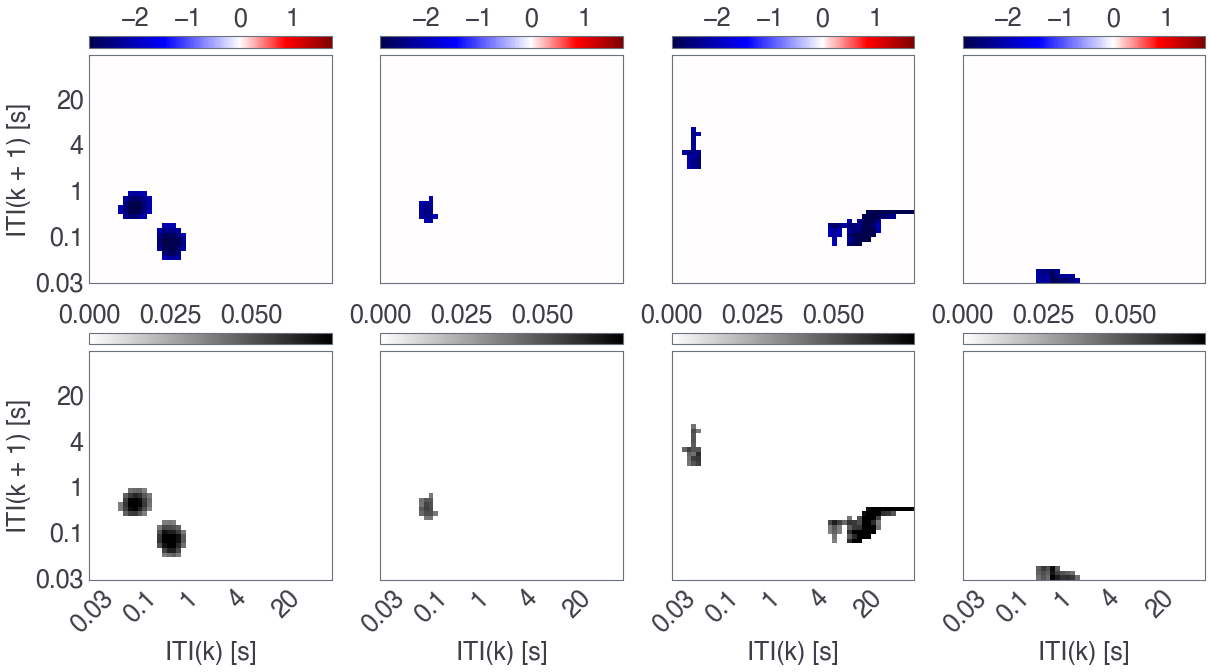

In [119]:
TITLES = ['cRT', 'switchGlobal',  'corsi'] 
VALUES = [res_cRT, res_global,  res_corsi]
fig, ax = plt.subplots(2, 4, figsize=(20, 10), sharey=True, sharex=True)

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

IDX = 1 # 0 == cRT // 2 == switchGlobal

vmax_f = -np.Inf
vmin_f = np.Inf
vmax_r = -np.Inf
vmin_r = np.Inf

for i in range(4):
#     data_it = res_cRT[i].flat[0][1].flat[0]
    data_it = VALUES[IDX][ORDER[i]].flat[0][2].flat[0]
    mask = data_it[0].reshape(50, 50).T
    p_vals = data_it[1].reshape(50, 50).T
    f_vals = data_it[2].reshape(50, 50).T
    r_vals = data_it[3].reshape(50, 50).T
    r2_vals = data_it[4].reshape(50, 50).T
    k = data_it[5][:, 0].reshape(50, 50).T

    f_vals[f_vals < 0] = 0
    
    vmax_f = max(vmax_f, np.percentile(np.sqrt(f_vals) * np.sign(k), 99))
    vmin_f = min(vmin_f, np.percentile(np.sqrt(f_vals) * np.sign(k), 1))
    
    vmax_r = max(vmax_r, np.percentile(r2_vals, 99))
    vmin_r = min(vmin_r, np.percentile(r2_vals, 1))

for i, _title in enumerate(['Full', 'Social', 'Transition', 'Launcher']):

    data_it = VALUES[IDX][ORDER[i]].flat[0][2].flat[0]
    mask = data_it[0].reshape(50, 50).T
    p_vals = data_it[1].reshape(50, 50).T
    f_vals = data_it[2].reshape(50, 50).T
    r_vals = data_it[3].reshape(50, 50).T
    r2_vals = data_it[4].reshape(50, 50).T
    k = data_it[5][:, 0].reshape(50, 50).T

    f_vals[f_vals < 0] = 0
    
    im = ax[0][i].imshow(np.sign(mask) * np.sqrt(f_vals) * np.sign(k), aspect='auto', 
                         cmap='seismic', interpolation='none', norm=TwoSlopeNorm(0, vmin=vmin_f, vmax=vmax_f))
#     im = ax[0][i].imshow(np.sign(masks_uni[IDX]) * np.sqrt(square_f) * np.sign(k), aspect='auto', cmap='seismic', interpolation='none')

    ax[0][i].invert_yaxis()
    ax[0][i].set_xticks(ticks)
    ax[0][i].set_xticklabels(labels)
    ax[0][i].xaxis.set_tick_params(rotation=45)
    ax[0][i].set_yticks(ticks)
    ax[0][i].set_yticklabels(labels)
#     ax[0][i].set_xlabel('ITI(k) [s]')
    ax[0][i].grid(False)
    divider = make_axes_locatable(ax[0][i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()
#     cb.set_ticks([0] + list(np.arange(min(_t), max(_t), 2)))
    
    # R2
#     r2_vals[r2_vals < 1e-5] = 0
    
    im = ax[1][i].imshow(np.sign(mask) * r2_vals, aspect='auto', cmap='binary',
                         interpolation='none', norm=Normalize(0, vmax_r))
#                          interpolation='none', norm=TwoSlopeNorm(0, vmin=-0.01, vmax=vmax_r))
    
    ax[1][i].invert_yaxis()
    ax[1][i].set_xticks(ticks)
    ax[1][i].set_xticklabels(labels)
    ax[1][i].xaxis.set_tick_params(rotation=45)
    ax[1][i].set_yticks(ticks)
    ax[1][i].set_yticklabels(labels)
    ax[1][i].set_xlabel('ITI(k) [s]')
    ax[1][i].grid(False)
    divider = make_axes_locatable(ax[1][i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()
#     _t = cb.set_ticks(np.arange(0.0, max(_t) + .1, .1))
    
ax[0][0].set_ylabel('ITI(k + 1) [s]');
ax[1][0].set_ylabel('ITI(k + 1) [s]');
# plt.tight_layout()
# if IDX == 0:
plt.savefig(f'figure_4_panel_b_{TITLES[IDX]}.pdf', transparent=True)
# else:
#     plt.savefig('figure_1_supplementary_ii.pdf', transparent=True)

# 

<ipython-input-72-4ce878da21e6>:22: UserWarning: No contour levels were found within the data range.
  im = ax[i].contour(Z * np.sign(mask), [4, 8, 16], colors=CMAPS[IDX], alpha=1, norm=norm, linestyles=['dotted', '--', '-'])


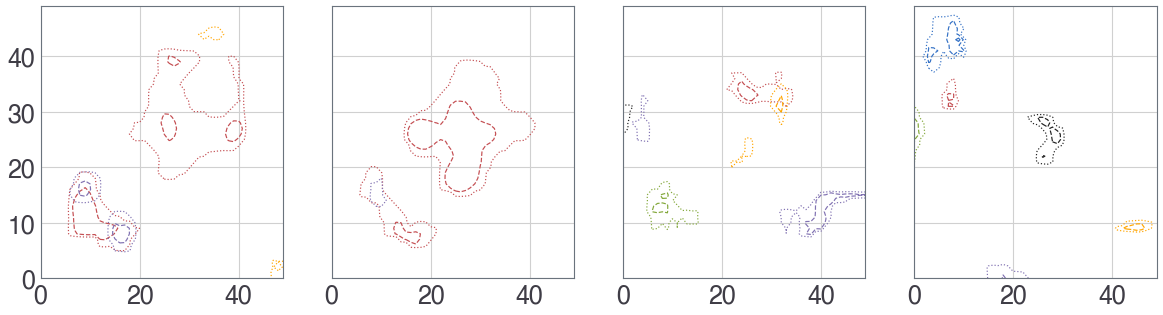

In [72]:
TITLES = ['cRT', 'sRT', 'switchGlobal', 'switchLocal', 'corsi', '2back'] 
VALUES = [res_cRT, res_sRT, res_global, res_local, res_corsi, res_2back]
CMAPS = ['r', 'b', 'm', 'g', 'orange', 'k']
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharey=True, sharex=True)

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]


for i, _title in enumerate(['Full', 'Social', 'Transition', 'Launcher']):
    for IDX in range(6):
        data_it = VALUES[IDX][ORDER[i]].flat[0][2].flat[0]
        mask = data_it[0].reshape(50, 50).T
        p_vals = data_it[1].reshape(50, 50).T
        f_vals = data_it[2].reshape(50, 50).T
        r_vals = data_it[3].reshape(50, 50).T
        r2_vals = data_it[4].reshape(50, 50).T
        k = data_it[5][:, 0].reshape(50, 50).T
        f_vals[f_vals < 0] = 0
        Z = f_vals
        norm = cm.colors.Normalize(vmax=abs(Z).max(), vmin=-abs(Z).max())
        im = ax[i].contour(Z * np.sign(mask), [4, 8, 16], colors=CMAPS[IDX], alpha=1, norm=norm, linestyles=['dotted', '--', '-'])
    

# else:
plt.savefig('figure_2_panel_c.pdf', transparent=True)